# Models

## Objective
* Model that has low latency
* Model that has very small in size
* Model with good accuracy

In [ ]:
%%writefile kaggle.json
{"username":"rushikeshdarge","key":"********************************"}

Writing kaggle.json


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rushikeshdarge/case-study-2-dataset
!unzip /content/case-study-2-dataset.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D

import os
import cv2
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# https://tutorialspoint4all.com/python-program-to-convert-bytes-to-kilobytes-megabytes-gigabytes-and-terabytes/
def convert_bytes(bytes_number):
    tags = [ "Byte", "Kilobyte", "Megabyte", "Gigabyte", "Terabyte" ]
 
    i = 0
    double_bytes = bytes_number
 
    while (i < len(tags) and  bytes_number >= 1024):
            double_bytes = bytes_number / 1024.0
            i = i + 1
            bytes_number = bytes_number / 1024
 
    return str(round(double_bytes, 2)) + " " + tags[i]

In [ ]:
# in neural network model.predict give little different output
# to check performance of Neural network
def performace_of_model_nn(model, history, y_train, X_train, y_test,X_test):
    # to check the performance of neural network model
    # predict using model
    y_train_pred = np.where(model.predict(X_train)[:,1] > 0.5, 1,0)
    y_test_pred = np.where(model.predict(X_test)[:,1] > 0.5, 1,0)

    y_train = np.argmax(y_train, axis=1)
    # print(y_train_pred)
    # printing classification report
    target_names = ['class 0', 'class 1']
    print('Classification report for train data is : \n')
    print(classification_report(y_train, y_train_pred, target_names=target_names))


    print('Classification report for test data is : \n')
    print(classification_report(y_test,y_test_pred, target_names=target_names))


    # creating confusion matrix
    cf_train = confusion_matrix(y_train,y_train_pred)
    cf_test = confusion_matrix(y_test,y_test_pred)
    cf_ideal = confusion_matrix(y_test,y_test)

    # heatmap of confusion matrix on train data
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sns.heatmap(cf_train/np.sum(cf_train), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Train Confusion matrix")

    # heatmap of confusion matrix on test data
    plt.subplot(1,2,2)
    sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Test Confusion matrix")
    plt.show()

    # plotting accuracy
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plotting loss 
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
ndf = pd.read_csv('/content/dataset.csv')
ndf.head()

,path,label
0,/content/CS2_dataset/NSFW/NSFW4458.jpg,1
1,/content/CS2_dataset/NSFW/NSFW5711.jpg,1
2,/content/CS2_dataset/NSFW/NSFW1982.jpg,1
3,/content/CS2_dataset/NSFW/NSFW6483.jpg,1
4,/content/CS2_dataset/NSFW/NSFW3529.jpg,1


In [ ]:
kdf = ndf.sample(10000)
train_d, test_d = train_test_split(kdf, test_size=0.20, random_state=42, stratify=kdf['label'])

In [ ]:
test_d.label.value_counts()

1    1019
0     981
Name: label, dtype: int64

## images to array

In [ ]:
# training_Data
img_size = 224

all_images_train = []
ex_y_train = []

n_img_temp = train_d[:2000]
for i in tqdm(range(len(n_img_temp['path']))):
    try:
        img = cv2.imread(n_img_temp.iloc[i]['path'])
        new_img = cv2.resize(img/255, (img_size, img_size))
        all_images_train.append(new_img)
        ex_y_train.append(int(n_img_temp.iloc[i]['label']))
    except:
        continue
ex_x_train = np.array(all_images_train)
ex_y_train = keras.utils.to_categorical(ex_y_train, 2)

100%|██████████| 2000/2000 [00:16<00:00, 124.54it/s]


In [ ]:
all_images_test = []
ex_y_test = []

n_img_temp = test_d[:300]
for i in tqdm(range(len(n_img_temp['path']))):
    try:
        img = cv2.imread(n_img_temp.iloc[i]['path'])
        new_img = cv2.resize(img/255, (img_size, img_size))
        all_images_test.append(new_img)
        ex_y_test.append(int(n_img_temp.iloc[i]['label']))
    except:
        continue
ex_x_test = np.array(all_images_test)

100%|██████████| 300/300 [00:01<00:00, 193.04it/s]


# Models

# Custom CNN 

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
# build keras model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                 input_shape=[224, 224, 3]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='min')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 8)       2312      
                                                                 
 flatten (Flatten)           (None, 380192)            0         
                                                                 
 dense (Dense)               (None, 128)               48664704  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 48,687,530
Trainable params: 48,687,530
No

In [ ]:
history = model.fit(ex_x_train, ex_y_train, batch_size=20, epochs=5, verbose=1,\
                    validation_split=0.20, callbacks=[early_stop])

Epoch 1/5
80/80 [==============================] - 19s 94ms/step - loss: 1.1299 - accuracy: 0.6406 - val_loss: 0.7076 - val_accuracy: 0.5725
Epoch 2/5
80/80 [==============================] - 7s 87ms/step - loss: 0.6231 - accuracy: 0.6825 - val_loss: 0.6332 - val_accuracy: 0.6525
Epoch 3/5
80/80 [==============================] - 7s 87ms/step - loss: 0.4021 - accuracy: 0.8238 - val_loss: 0.7679 - val_accuracy: 0.6700
Epoch 4/5
80/80 [==============================] - 7s 88ms/step - loss: 0.1787 - accuracy: 0.9344 - val_loss: 1.1409 - val_accuracy: 0.6650
Epoch 5/5
80/80 [==============================] - 7s 87ms/step - loss: 0.0858 - accuracy: 0.9750 - val_loss: 1.6427 - val_accuracy: 0.6475


Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.91      0.93      0.92       953
     class 1       0.93      0.91      0.92      1047

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.61      0.75      0.67       140
     class 1       0.72      0.57      0.64       160

    accuracy                           0.66       300
   macro avg       0.67      0.66      0.66       300
weighted avg       0.67      0.66      0.66       300



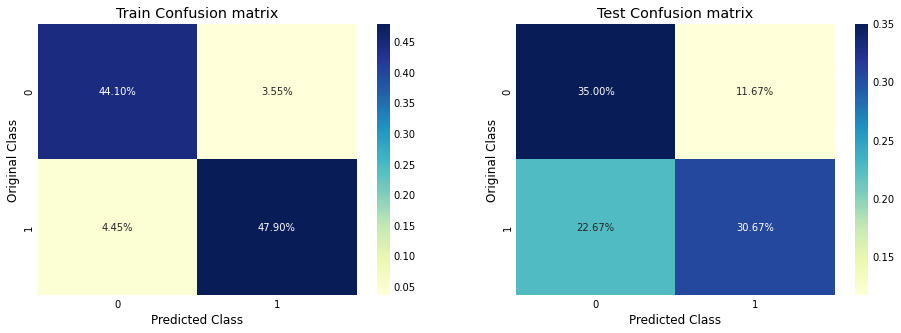

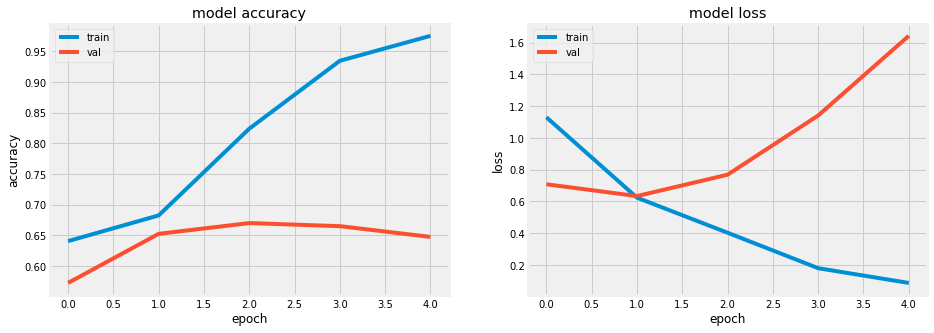

In [ ]:
performace_of_model_nn(model, history, ex_y_train, ex_x_train, ex_y_test, ex_x_test)

In [ ]:
%timeit model.predict(np.expand_dims(ex_x_test[0],0))

10 loops, best of 5: 39.1 ms per loop


In [ ]:
%timeit model.predict(ex_x_test)

The slowest run took 4.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 561 ms per loop


In [ ]:
model.save("cnn_from_scratch.h5")
convert_bytes(os.path.getsize('cnn_from_scratch.h5'))

'557.23 Megabyte'

* we have 48 Million parameters
* Model size is 557.23 MB
* we have only 6 Layers and model is overfitting

# ResNet50

In [ ]:
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3))

for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

resnet50 = Model(inputs = resnet.input, outputs = predictions)



# compile model
resnet50.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='min')

resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history = resnet50.fit(ex_x_train, ex_y_train, batch_size=20, epochs=7, verbose=1,\
                    validation_split=0.20, callbacks=[early_stop])

Epoch 1/7
80/80 [==============================] - 20s 100ms/step - loss: 0.9870 - accuracy: 0.6450 - val_loss: 0.5777 - val_accuracy: 0.7150
Epoch 2/7
80/80 [==============================] - 7s 82ms/step - loss: 0.5533 - accuracy: 0.7412 - val_loss: 0.6079 - val_accuracy: 0.7425
Epoch 3/7
80/80 [==============================] - 7s 83ms/step - loss: 0.5153 - accuracy: 0.7788 - val_loss: 0.5692 - val_accuracy: 0.7450
Epoch 4/7
80/80 [==============================] - 7s 84ms/step - loss: 0.4471 - accuracy: 0.8062 - val_loss: 0.4935 - val_accuracy: 0.7800
Epoch 5/7
80/80 [==============================] - 7s 84ms/step - loss: 0.5385 - accuracy: 0.7444 - val_loss: 0.5020 - val_accuracy: 0.7700
Epoch 6/7
80/80 [==============================] - 7s 85ms/step - loss: 0.4280 - accuracy: 0.8100 - val_loss: 0.4812 - val_accuracy: 0.7775
Epoch 7/7
80/80 [==============================] - 7s 86ms/step - loss: 0.4080 - accuracy: 0.8156 - val_loss: 0.4843 - val_accuracy: 0.7650


In [ ]:
resnet50.save("resnet50_model.h5")
convert_bytes(os.path.getsize('resnet50_model.h5'))

'205.34 Megabyte'

Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.76      0.90      0.83       953
     class 1       0.89      0.75      0.81      1047

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.78      0.88      0.83       140
     class 1       0.88      0.79      0.83       160

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.84      0.83      0.83       300



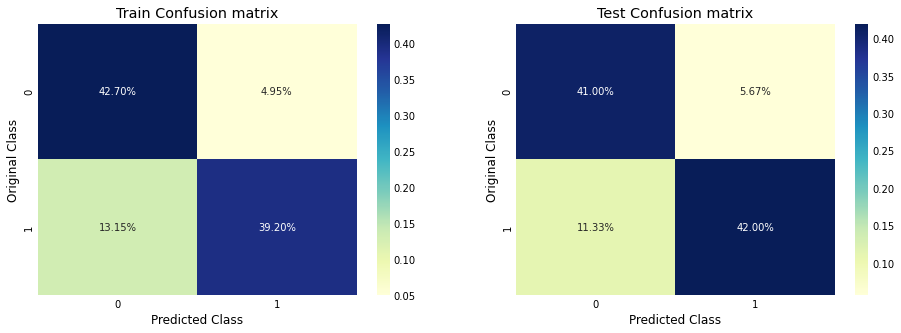

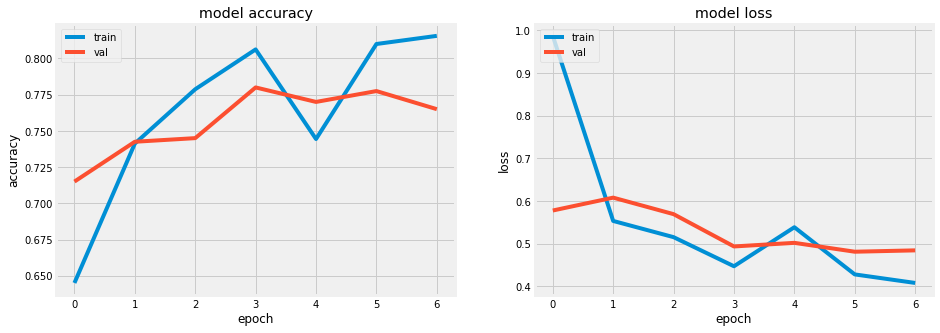

In [ ]:
performace_of_model_nn(resnet50, history, ex_y_train, ex_x_train, ex_y_test, ex_x_test)

In [ ]:
%timeit resnet50.predict(np.expand_dims(ex_x_test[0],0))

The slowest run took 10.18 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 44.5 ms per loop


In [ ]:
%timeit resnet50.predict(ex_x_test)

1 loop, best of 5: 1.04 s per loop


* we have 36 Million parameters
* Model size is 240 MB

In [ ]:
np.save('ex_y_train',ex_y_train)
np.save('ex_x_train',ex_x_train)
np.save('ex_y_test',ex_y_test)
np.save('ex_x_test',ex_x_test)

In [ ]:
ex_y_train = np.load('ex_y_train.npy')
ex_x_train = np.load('ex_x_train.npy')
ex_y_test = np.load('ex_y_test.npy')
ex_x_test = np.load('ex_x_test.npy')

# EfficientNetB0

In [ ]:
eff_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3))

for layer in eff_model.layers:
    layer.trainable = False

x = Flatten()(eff_model.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

efficient_m = Model(inputs=eff_model.input, outputs=predictions)

# compile model
efficient_m.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='min')

efficient_m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
history = efficient_m.fit(ex_x_train, ex_y_train, batch_size=20, epochs=7, verbose=1,\
                    validation_split=0.20, callbacks=[early_stop])

Epoch 1/7
80/80 [==============================] - 22s 94ms/step - loss: 1.0228 - accuracy: 0.4944 - val_loss: 0.7130 - val_accuracy: 0.5325
Epoch 2/7
80/80 [==============================] - 5s 67ms/step - loss: 0.7121 - accuracy: 0.5044 - val_loss: 0.6946 - val_accuracy: 0.5325
Epoch 3/7
80/80 [==============================] - 5s 59ms/step - loss: 0.7054 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.5325
Epoch 4/7
80/80 [==============================] - 4s 54ms/step - loss: 0.6930 - accuracy: 0.5213 - val_loss: 0.6927 - val_accuracy: 0.5325
Epoch 5/7
80/80 [==============================] - 4s 54ms/step - loss: 0.6928 - accuracy: 0.5213 - val_loss: 0.6924 - val_accuracy: 0.5325
Epoch 6/7
80/80 [==============================] - 4s 54ms/step - loss: 0.6927 - accuracy: 0.5213 - val_loss: 0.6923 - val_accuracy: 0.5325
Epoch 7/7
80/80 [==============================] - 4s 53ms/step - loss: 0.7036 - accuracy: 0.5175 - val_loss: 0.6920 - val_accuracy: 0.5325


In [ ]:
efficient_m.save("efficient_model.h5")
convert_bytes(os.path.getsize('efficient_model.h5'))

'87.87 Megabyte'

Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       953
     class 1       0.52      1.00      0.69      1047

    accuracy                           0.52      2000
   macro avg       0.26      0.50      0.34      2000
weighted avg       0.27      0.52      0.36      2000

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       140
     class 1       0.53      1.00      0.70       160

    accuracy                           0.53       300
   macro avg       0.27      0.50      0.35       300
weighted avg       0.28      0.53      0.37       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

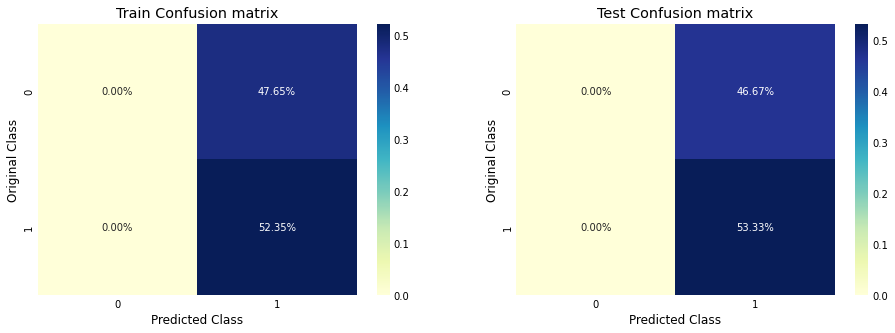

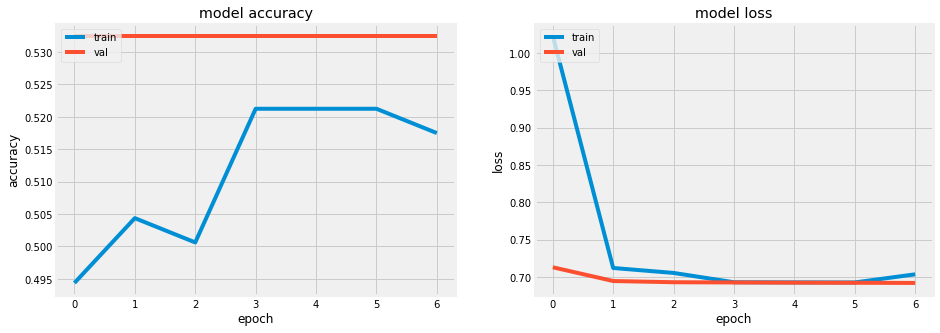

In [ ]:
performace_of_model_nn(efficient_m, history, ex_y_train, ex_x_train, ex_y_test, ex_x_test)

In [ ]:
%timeit efficient_m.predict(np.expand_dims(ex_x_test[0],0))

The slowest run took 14.64 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 45.6 ms per loop


In [ ]:
%timeit efficient_m.predict(ex_x_test)

1 loop, best of 5: 755 ms per loop


* we have 12 Million parameters
* Model size is 87 MB

# MobileNet V2

In [ ]:
mob_m = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet')

for layer in mob_m.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(mob_m.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

mobilenet_m = Model(inputs=mob_m.input, outputs=predictions)

# compile model
mobilenet_m.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='min')

mobilenet_m.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
history = mobilenet_m.fit(ex_x_train, ex_y_train, batch_size=20, epochs=5, verbose=1,\
                    validation_split=0.20, callbacks=[early_stop])

Epoch 1/5
80/80 [==============================] - 6s 50ms/step - loss: 0.1543 - accuracy: 0.9337 - val_loss: 0.1220 - val_accuracy: 0.9600
Epoch 2/5
80/80 [==============================] - 3s 37ms/step - loss: 0.0455 - accuracy: 0.9869 - val_loss: 0.1187 - val_accuracy: 0.9650
Epoch 3/5
80/80 [==============================] - 3s 37ms/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.1194 - val_accuracy: 0.9625
Epoch 4/5
80/80 [==============================] - 3s 37ms/step - loss: 0.0102 - accuracy: 0.9994 - val_loss: 0.1334 - val_accuracy: 0.9700
Epoch 5/5
80/80 [==============================] - 3s 37ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1377 - val_accuracy: 0.9650


Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99       953
     class 1       1.00      0.99      0.99      1047

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       1.00      0.97      0.99       140
     class 1       0.98      1.00      0.99       160

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



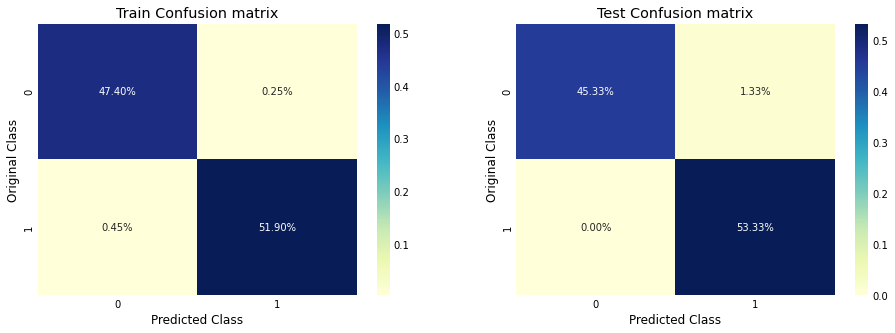

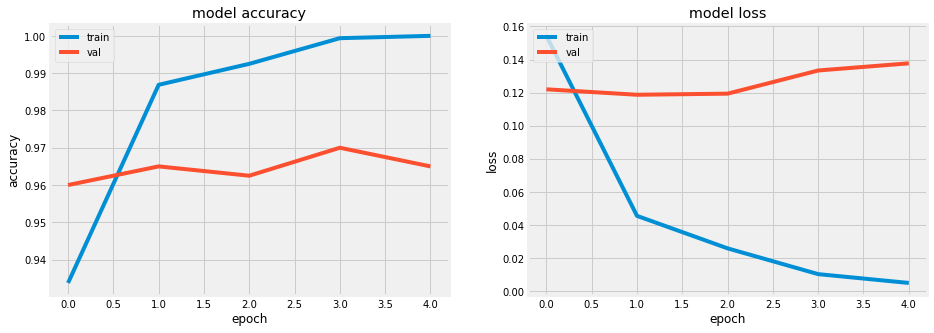

In [ ]:
performace_of_model_nn(mobilenet_m, history, ex_y_train, ex_x_train, ex_y_test, ex_x_test)

In [ ]:
np.expand_dims(ex_x_test[0],0)

(1, 224, 224, 3)

In [ ]:
ex_x_test.shape

(300, 224, 224, 3)

In [ ]:
%timeit mobilenet_m.predict(np.expand_dims(ex_x_test[0],0))

The slowest run took 8.85 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 41.2 ms per loop


In [ ]:
%timeit mobilenet_m.predict(ex_x_test)

1 loop, best of 5: 566 ms per loop


In [ ]:
mobilenet_m.save("mobilenet_v2_model.h5")
convert_bytes(os.path.getsize('mobilenet_v2_model.h5'))

'10.55 Megabyte'

* we have 2 Million parameters
* Model size is 10.5 MB
* Model is good fit and size also small as compare to other models

In [ ]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
summary_table = PrettyTable(["Name of model","No. of Param", "Size of model", "Train acc", "Test acc", "Time 1 image", "Time 300 images"])

# Add rows
summary_table.add_row(["Custom CNN","48 Million", "560 MB", "92 %", "67 %", "37.5 ms", "561 ms"])
summary_table.add_row(["ResNet","36 Million", "240 MB", "83 %", "83 %", "44.5 ms", "1 sec"])
summary_table.add_row(["EfficientNet","12 Million", "87  MB", "51 %", "53 %", "45.6 ms", "755 ms"])
summary_table.add_row(["MobileNet","2  Million", "10  MB", "99 %", "99 %", "41.2 ms", "566 ms"])

print(summary_table)


+---------------+--------------+---------------+-----------+----------+--------------+-----------------+
| Name of model | No. of Param | Size of model | Train acc | Test acc | Time 1 image | Time 300 images |
+---------------+--------------+---------------+-----------+----------+--------------+-----------------+
|   Custom CNN  |  48 Million  |     560 MB    |    92 %   |   67 %   |   37.5 ms    |      561 ms     |
|     ResNet    |  36 Million  |     240 MB    |    83 %   |   83 %   |   44.5 ms    |      1 sec      |
|  EfficientNet |  12 Million  |     87  MB    |    51 %   |   53 %   |   45.6 ms    |      755 ms     |
|   MobileNet   |  2  Million  |     10  MB    |    99 %   |   99 %   |   41.2 ms    |      566 ms     |
+---------------+--------------+---------------+-----------+----------+--------------+-----------------+


# Summary
We can see that the best model in terms of speed, size, and accuracy is MobileNet.
* We can write MobileNet from scratch, and we can reduce its size further by reducing the number of layers.
* Because this model is trained on the imagenet dataset, which has 1000 classes, to classify those 1000 classes, we need more features from the image.
* However, because we only have two classes, our model can easily perform very well with fewer features and fewer layers.
* and because of less computation speed of our model is  increase.